In [1]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### FitzHugh-Nagumo

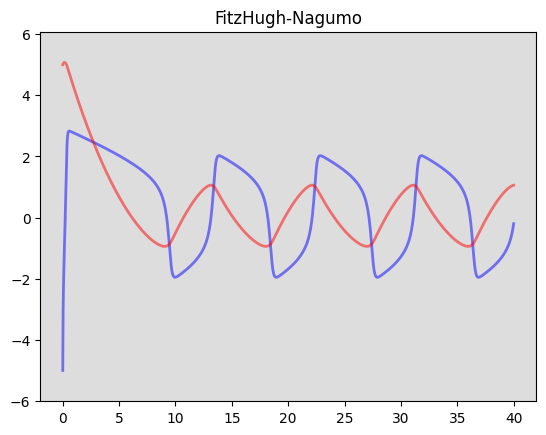

In [2]:
# define FitzHugh-Nagumo model dynamic
def FN(y, t, a, b, c):
	V, R = y
	dVdt = c * (V - np.power(V,3)/3.0 + R)
	dRdt = -1./c * (V - a + b*R)
	return (dVdt,dRdt)

# model parameters 
a, b, c = 0.2, 0.2, 3
# initial condition
V0 = -5
R0 = 5
y0 = V0, R0
# time point for evaluation
tdata = np.linspace(0, 40, 1281)
# integration
xdata = odeint(FN, y0, tdata, args = (a,b,c))
# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='V')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='R')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('FitzHugh-Nagumo')
plt.show()

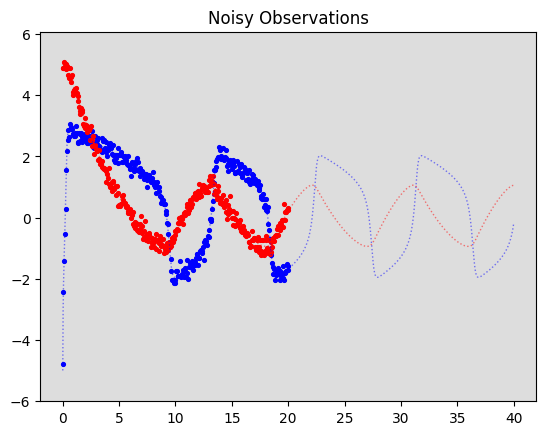

In [3]:
# setting
seed = 188714368 # random seed
noise = [0.15,0.15] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [4]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 54.401185
200/1000 iteration: 12.249576
400/1000 iteration: 7.344614
600/1000 iteration: 5.518925
800/1000 iteration: 4.613518
1000/1000 iteration: 4.089384
run time: 19.43 seconds


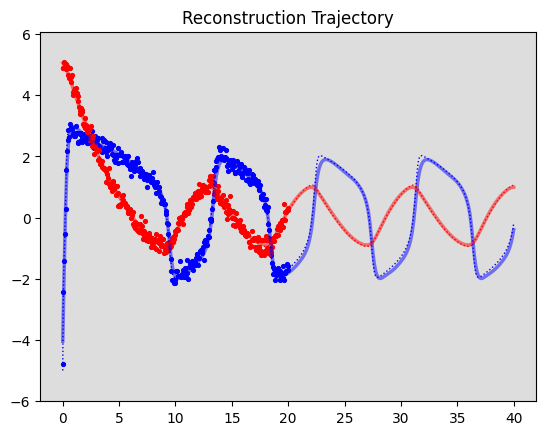

In [5]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [6]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 44.984771
200/1000 iteration: 9.273745
400/1000 iteration: 5.649792
600/1000 iteration: 4.426879
800/1000 iteration: 3.836140
1000/1000 iteration: 3.491261
run time: 27.63 seconds


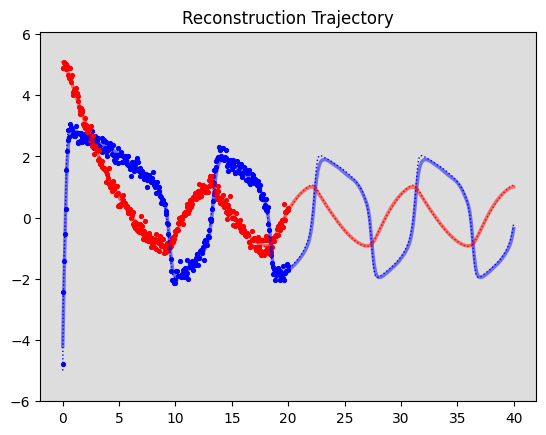

In [7]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Hes1

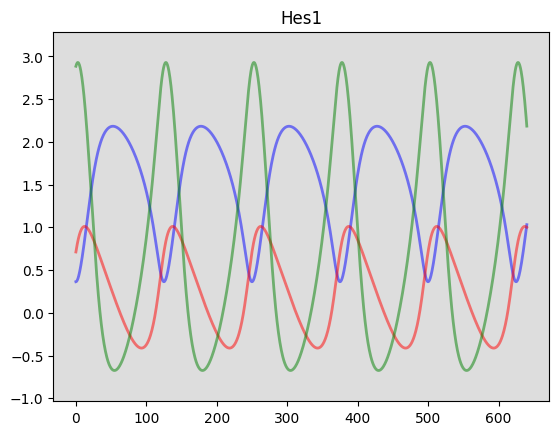

In [73]:
# define Hes1 model dynamic
def fOde(y, t, a, b, c, d, e, f, g):
	P, M, H = y
	dPdt = -a*P*H + b*M - c*P
	dMdt = -d*M + e/(1+np.power(P,2))
	dHdt = -a*P*H + f/(1+np.power(P,2)) - g*H
	return (dPdt,dMdt,dHdt)

# model parameters
a, b, c, d, e, f, g = 0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3
# initial condition
P0, M0, R0 = 1.438575, 2.037488, 17.90385
y0 = P0, M0, R0
# time point for evaluation
tdata = np.linspace(0, 640, 1281)
# integration 
xdata = odeint(fOde, y0, tdata, args = (a,b,c,d,e,f,g))
xdata = np.log(xdata)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='P')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='M')
ax.plot(tdata, xdata[:,2], 'g', alpha=0.5, lw=2, label='H')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Hes1')
plt.show()

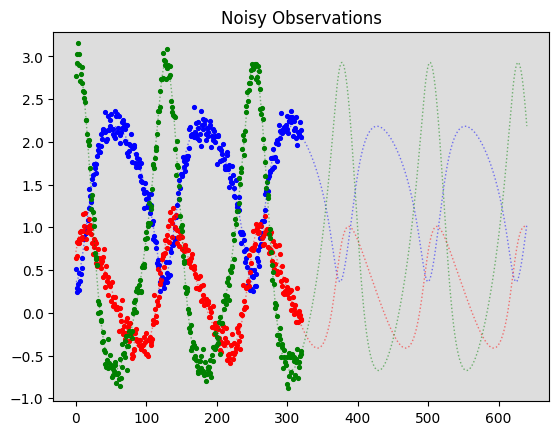

In [74]:
# setting
seed = 188714368 # random seed
noise = [0.10,0.10,0.10] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [75]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 10.348901
200/1000 iteration: 5.355932
400/1000 iteration: 4.250715
600/1000 iteration: 3.880846
800/1000 iteration: 3.737145
1000/1000 iteration: 3.670603
run time: 25.51 seconds


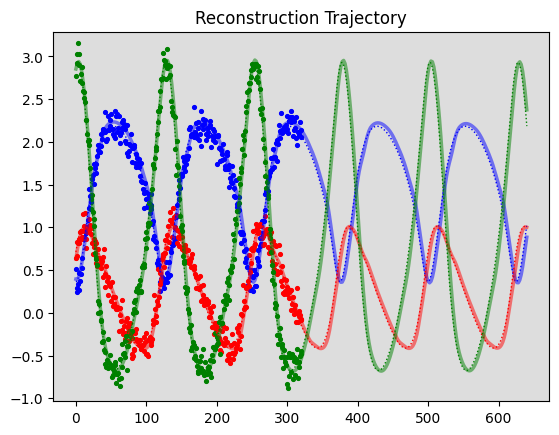

In [76]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [77]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 10.154749
200/1000 iteration: 5.288609
400/1000 iteration: 4.224643
600/1000 iteration: 3.860401
800/1000 iteration: 3.720408
1000/1000 iteration: 3.654091
run time: 35.65 seconds


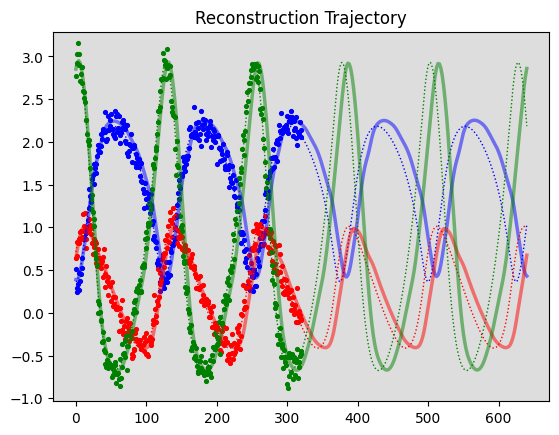

In [78]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Loren 96

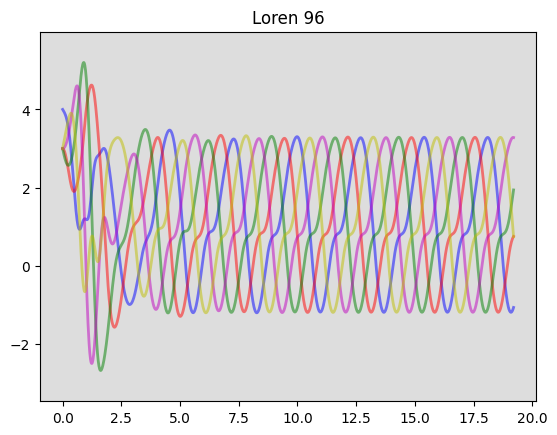

In [92]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 3
# initial conditions
y0 = F * np.ones(5)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 19.2, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

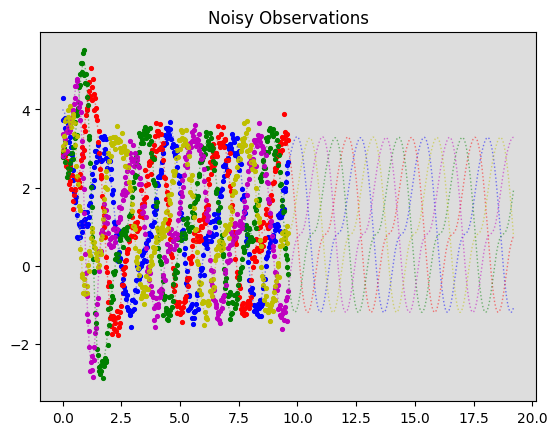

In [93]:
# setting
seed = 188714368 # random seed
noise = [0.2] * xdata.shape[1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [94]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 42.481572
200/1000 iteration: 12.836390
400/1000 iteration: 8.454057
600/1000 iteration: 7.042123
800/1000 iteration: 6.477923
1000/1000 iteration: 6.224532
run time: 62.60 seconds


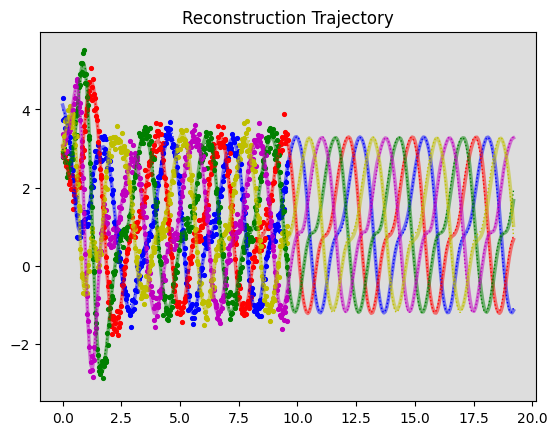

In [95]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [81]:
# MAP Inference - Multi Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 58.496724
200/1000 iteration: 16.048428
400/1000 iteration: 9.702938
600/1000 iteration: 7.649024
800/1000 iteration: 6.817555
1000/1000 iteration: 6.430939
run time: 41.60 seconds


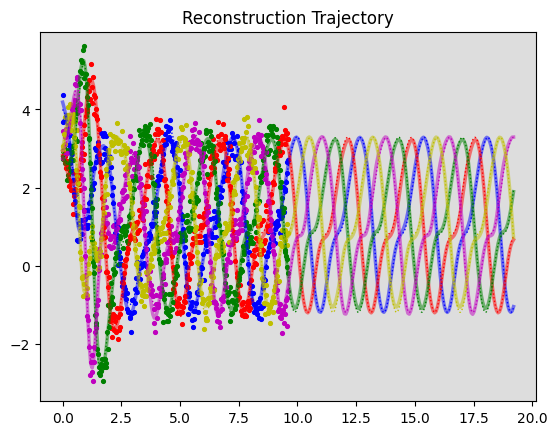

In [82]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Loren 96 Chaotic

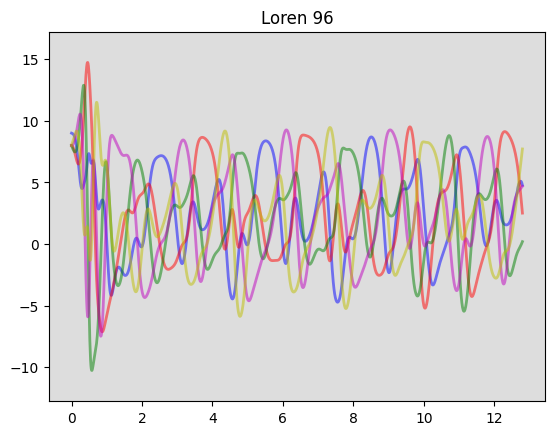

In [47]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 8
# initial conditions
y0 = F * np.ones(5)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 12.8, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

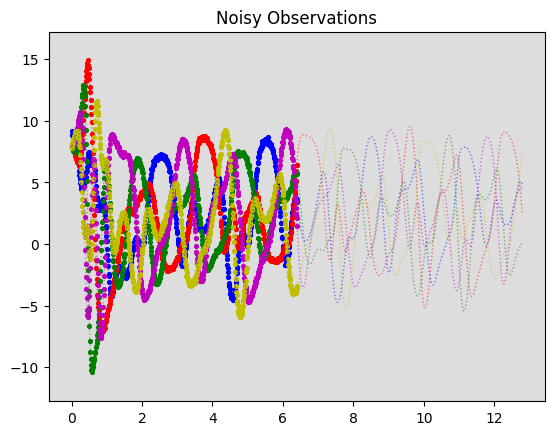

In [48]:
# setting
seed = 188714368 # random seed
noise = [0.10] * 5 # noise level
no_train = 641 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [49]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 18.281010
200/1000 iteration: 14.257597
400/1000 iteration: 13.599428
600/1000 iteration: 13.268598
800/1000 iteration: 13.052236
1000/1000 iteration: 12.889098
run time: 75.56 seconds


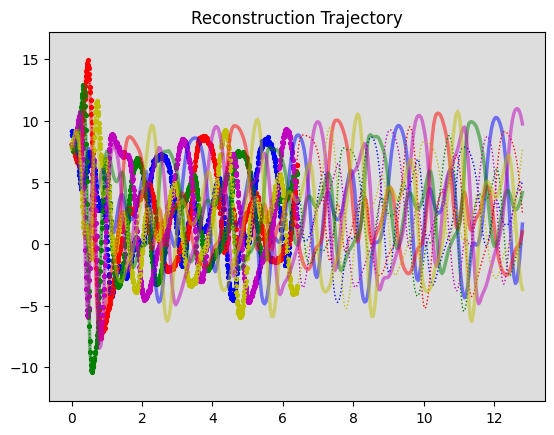

In [50]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Climate Data

In [51]:
climate = pd.read_csv("data/DailyDelhiClimate.csv")
climate.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [52]:
# preprocess data
tmax = 1000 # consider only first 1000 data points for now
tdata = climate.index.to_numpy()[:tmax] # time
xdata = climate.iloc[:tmax,1:].to_numpy() # component values
xdata = np.log(xdata + 1e-3) # train it in log
xdata = (xdata - np.mean(xdata, axis=0))/np.std(xdata, axis=0) # standardization

# observation
tmax_train = 500
no_comp = xdata.shape[1] # number of components
obs = [] # set random seed for noise
for i in range(no_comp):
    tobs = tdata[:tmax_train].copy()
    yobs = xdata[:tmax_train,i].copy()
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))

In [58]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=251,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 17.869349
200/1000 iteration: 9.893996
400/1000 iteration: 7.764493
600/1000 iteration: 6.928090
800/1000 iteration: 6.539244
1000/1000 iteration: 6.332493
run time: 53.55 seconds


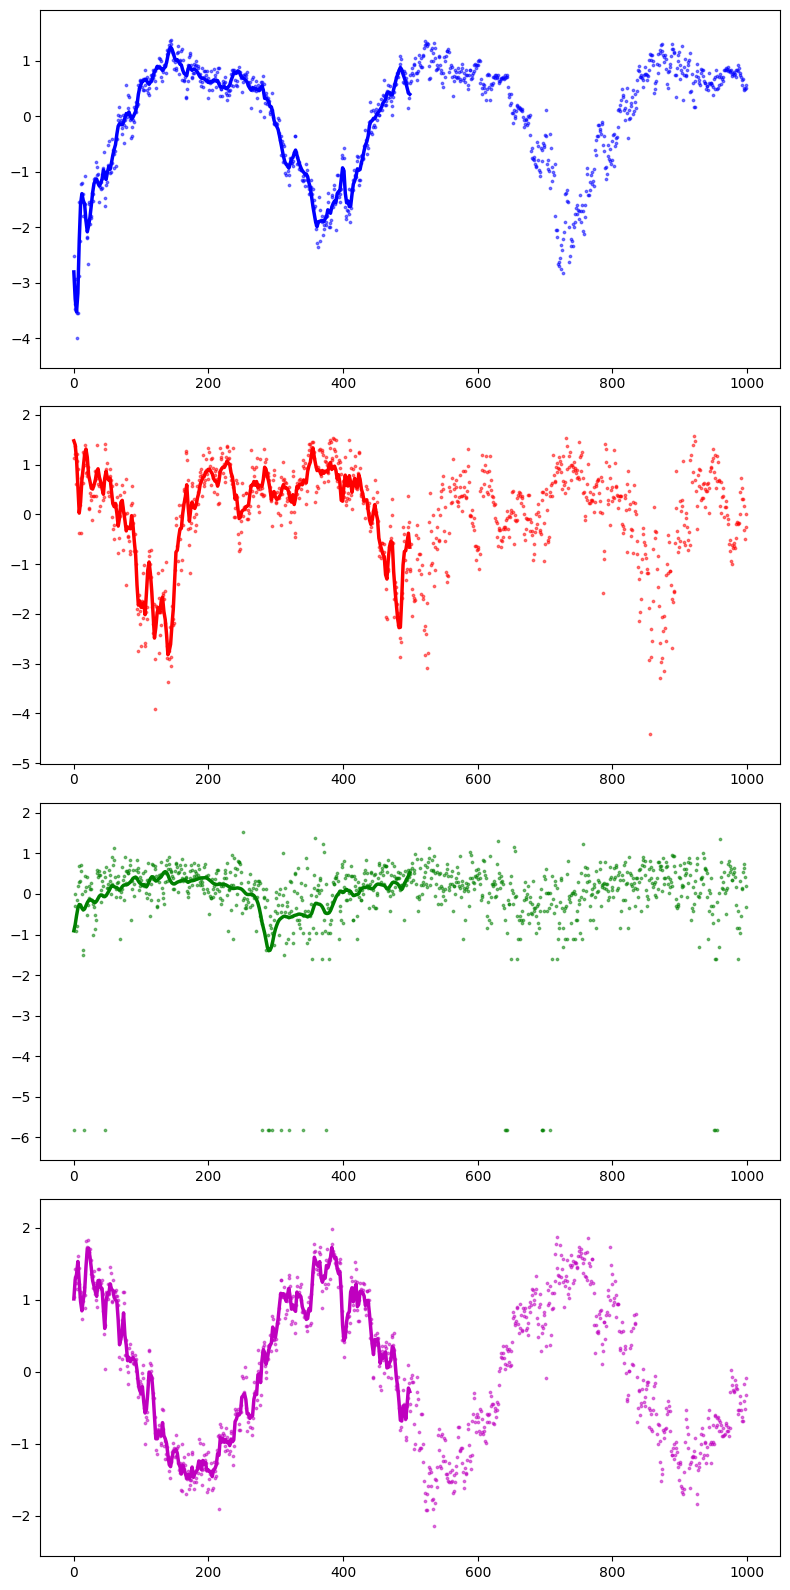

In [59]:
# inferred 
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(figsize=(8,16), facecolor='w')
for i in range(no_comp):
    ax = fig.add_subplot(no_comp, 1, (i+1))
    ax.plot(tinfer, xinfer[:,i], color=col[i], lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=3, marker='o', color=col[i], alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
fig.tight_layout()
plt.show()

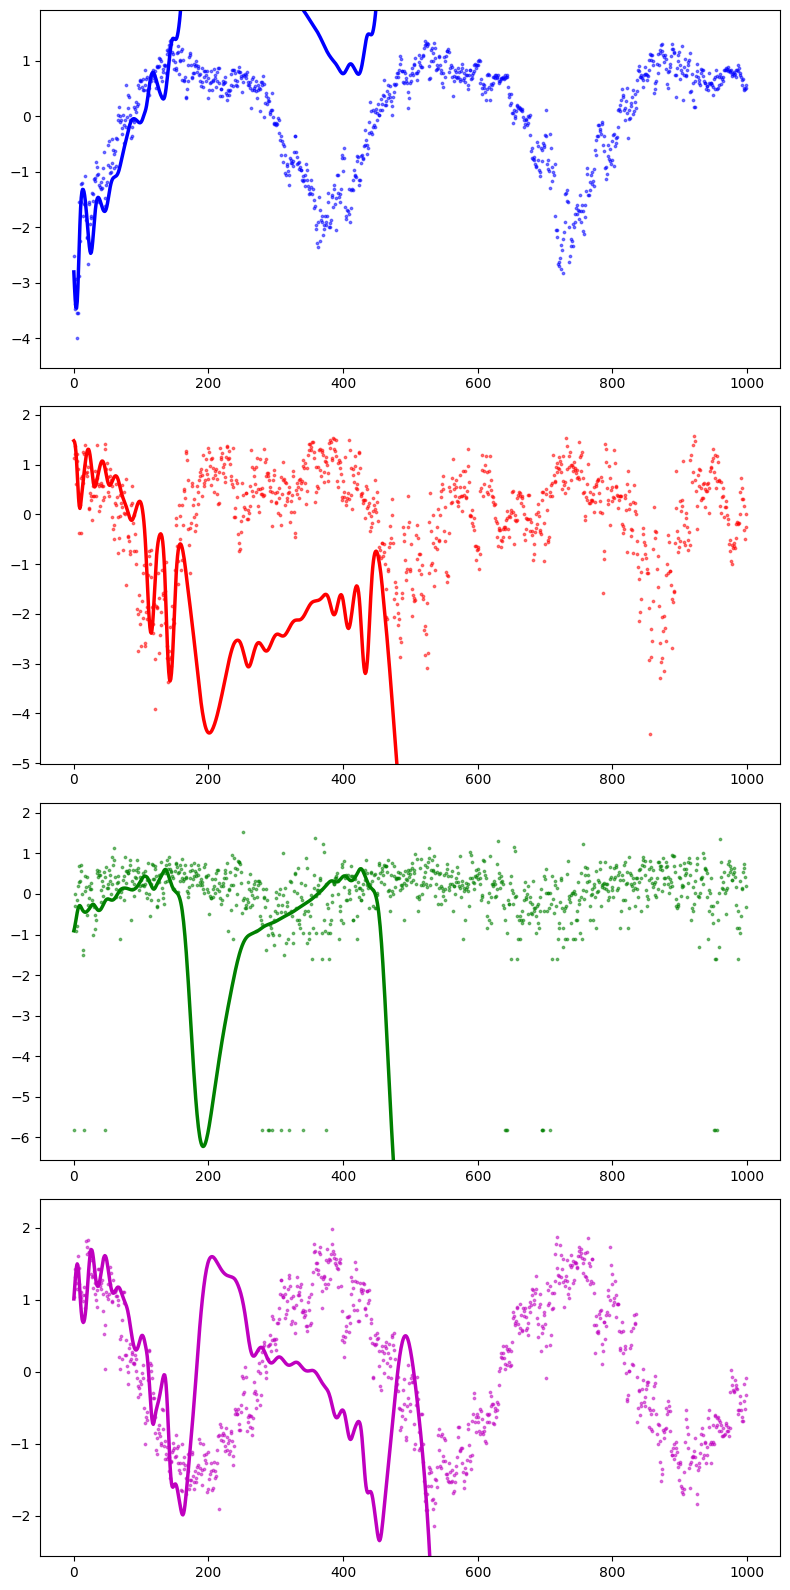

In [60]:
# reconstruction 
trecon = tdata
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(figsize=(8,16), facecolor='w')
for i in range(no_comp):
    ax = fig.add_subplot(no_comp, 1, (i+1))
    ax.plot(tr, xr[:,i], color=col[i], lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=3, marker='o', color=col[i], alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
fig.tight_layout()
plt.show()